### Initial

In [61]:
# imports
import os
import csv
import urllib.request

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data processing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import label_binarize, PolynomialFeatures

# models
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn import linear_model, svm
import torch
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier

# embedding
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedKFold, KFold
import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from scipy.special import softmax
from sklearn.decomposition import PCA, KernelPCA

# model tuning
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.utils import parallel_backend


Import Dataset

In [62]:
# Import data from /dataset/
team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

### Exploratory Analysis

In [63]:
df.head(10)

,id,text,type,author_id,possibly_sensitive,retweet_count,quote_count,reply_count,like_count,followers_count,following_count,tweet_count,listed_count,words,score_compound,sentiment
0,1532325760148590593,@xbresson British Alps :-),replied_to,62044012,False,0,0,1,2,33022,3383,5246,359,"['british', 'alps']",0.0000,neutral
1,1312410689059913731,RT @Aistats2020: Videos presentations of paper...,retweeted,1290762290224984064,False,52,0,0,0,17570,541,703,222,"['videos', 'presentations', 'papers', 'keynote...",0.0000,neutral
2,1564467011781926913,I hope I would be able to talk more about this...,quoted,3363584909,False,1,0,0,3,65506,113,15406,856,"['hope', 'would', 'able', 'talk', 'balcony', '...",0.4862,neutral
3,1473395733344788481,RT @dlbcnai: Keynote by Joan Bruna (@joanbruna...,retweeted,1071640880,False,35,0,0,0,21847,555,1346,264,"['keynote', 'joan', 'bruna', 'geometric', 'dee...",0.3612,neutral
4,1611495430843502593,@annargrs @Michael_J_Black @AllenHW0 @CSProfKG...,replied_to,48008938,False,0,0,1,5,427851,582,12949,6488,"['process', 'science', 'relies', 'much', 'basi...",-0.3182,neutral
5,1228672069333848064,RT @geoffreyhinton: Unsupervised learning of r...,retweeted,1071640880,False,519,0,0,0,21847,555,1346,264,"['unsupervised', 'learning', 'representations'...",0.3384,neutral
6,1595340090963857410,"@prem_k Relax, it's a joke!",replied_to,48008938,False,0,0,2,2,427851,582,12949,6488,"['relax', 'joke']",0.6249,positive
7,1585623984858869765,Postdoctoral position available in Computation...,tweet,62044012,False,18,1,0,68,33022,3383,5246,359,"['postdoctoral', 'position', 'available', 'com...",0.4404,neutral
8,1529505378911891457,@textfiles I did note the irony of being somew...,replied_to,175624200,False,0,0,2,20,1031629,225,16316,6967,"['note', 'irony', 'somewhat', 'phone', 'phreak...",-0.3969,neutral
9,1624987333522239489,@repligate @reality__gamer are you sure it nev...,replied_to,232294292,False,0,0,2,0,86646,5312,26291,2422,"['sure', 'never', 'made', 'illegal', 'moves', ...",0.4449,positive


In [64]:
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']


num_total = len(df)
num_pos = len(df_pos)
num_neu = len(df_neu)
num_neg = len(df_neg)

print(f"Num. positive tweets: {num_pos} ({num_pos/num_total*100:.2f}%)")
print(f"Num. negative tweets: {num_neg} ({num_neg/num_total*100:.2f}%)")
print(f"Num. neutral tweets: {num_neu} ({num_neu/num_total*100:.2f}%)")


Num. positive tweets: 2228 (27.85%)
Num. negative tweets: 482 (6.02%)
Num. neutral tweets: 5290 (66.12%)


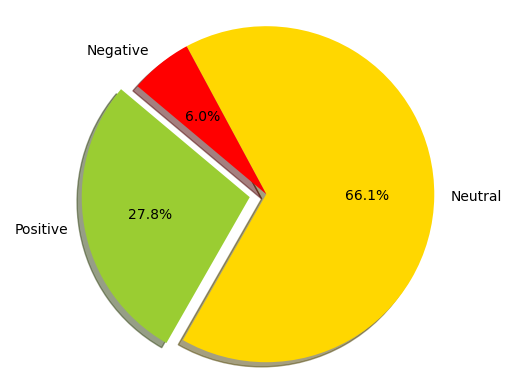

In [65]:
# Plot the sentiments in a pie chart

labels = ['Positive', 'Neutral', 'Negative']

sizes = [num_pos, num_neu, num_neg]

colors = ['yellowgreen', 'gold', 'red']

explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


### Loading Embedding Models

In [66]:
# convert the words column to string
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

# Specify the model name
name = 'all-mpnet-base-v2'

# Load the SentenceTransformer model
model = SentenceTransformer(f'models/{name}', device='cuda')


No sentence-transformers model found with name models/all-mpnet-base-v2. Creating a new one with MEAN pooling.


In [ ]:
# Create new embeddings for the dataset

# # List of sentences to get embeddings for
# sentences = list(df.words_str.values)
# sentences_test = list(df_test.words_str.values)

# # Get the sentence embeddings
# sentence_embeddings = model.encode(sentences)
# sentence_embeddings_test = model.encode(sentences_test)

# # save the embeddings
# np.save(f'embeddings/{name}_train.npy', sentence_embeddings)
# np.save(f'embeddings/{name}_test.npy', sentence_embeddings_test)

In [67]:
# load locally saved embeddings
sentence_embeddings = np.load(f'embeddings/{name}_train.npy')
sentence_embeddings_test = np.load(f'embeddings/{name}_test.npy')

### Plotting Functions

In [68]:
#define some functions for plotting purposes

def plot_y_continous(y, bins=10, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.hist(y, bins=bins)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()

def plot_scatter(x, y,  show=True, x_label=None, y_label=None,  title=None):
    fig, ax = plt.subplots(1, 1)
    _ = ax.scatter(x,y)
    if isinstance(title, str):
        ax.set_title(title)
    if isinstance(x_label, str):
        ax.set_xlabel(x_label)
    if isinstance(y_label, str):
        ax.set_ylabel(y_label)
    plt.tight_layout()
    if show: plt.show()

def plot_y_discrete(y, show=True, title=None):
    fig, ax = plt.subplots(1, 1)
    sns.countplot(x=y, palette=colors, ax=ax)
    if isinstance(title, str):
        ax.set_title(title)
    plt.tight_layout()
    if show: plt.show()
    

### Regression Task

Create feature matrix and target vector

In [ ]:
#create X (feature matrix) and y (targets)
X = sentence_embeddings
y = df.score_compound.values
print(f"X: {X.shape}")
print(f"y: {y.shape}")

#split X and y for training and validation purposes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

In [ ]:
plt.close('all')
plot_y_continous(y, bins=20, title='Histogram of Target variable')

Linear Regression

In [ ]:
#create our linear regression model
reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)

# train the model
reg = reg.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")
    

In [ ]:
#plot the histogram of learnt weights w_i 
plot_y_continous(reg.coef_, bins=20, title='Histogram of Parameters (w) learnt')

Ridge Regression

In [ ]:
# define Ridge regression model
model = Ridge()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
grid = dict()
# grid['alpha'] = np.arange(0, 1, 0.01)
grid['alpha'] = np.logspace(-5, 5, 300)
reg = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')

# train the model
print('Training...')
reg = reg.fit(X_train, y_train)

# summarize performance
print('MAE: %.3f' % reg.best_score_)
print('Best Alpha: %s' % reg.best_params_['alpha'])

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")


Lasso Regression

In [ ]:
# define Lasso regression model
model = Lasso()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
grid = dict()
# grid['alpha'] = np.arange(0, 1, 0.01)
grid['alpha'] = np.logspace(-5, 5, 50)
reg = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')

# train the model
print('Training...')
reg = reg.fit(X_train, y_train)

# summarize performance
print('Best MAE: %.3f' % reg.best_score_)
print('Best Alpha: %s' % reg.best_params_['alpha'])

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'valididation'], datasets):
    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f'\nSplit: {split_name}')
    print(f"\tRMSE: {rmse:.2f}")
    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")
    acc = skm.r2_score(y_i, y_pred)
    print(f"\tR2: {acc:.2f}")


Save the best model for test set

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
X_test = sentence_embeddings_test
y_hat = reg.predict(X_test)

# Save the results with the format <TEAM_ID>__<SPLIT>_reg_pred.npy
directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__reg_pred.npy'), y_hat)

### Classification

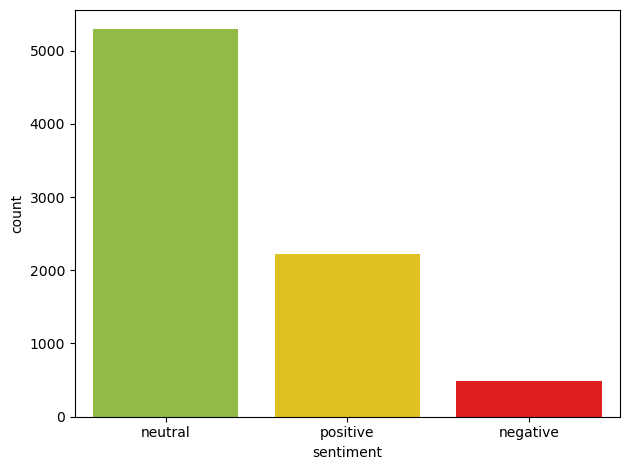

In [69]:
plot_y_discrete(df.sentiment)

Data preprocessing for classification

In [70]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (8000, 768)
y: (8000,) [0 1 2]


Print principal component distribution for each class

(8000, 3)


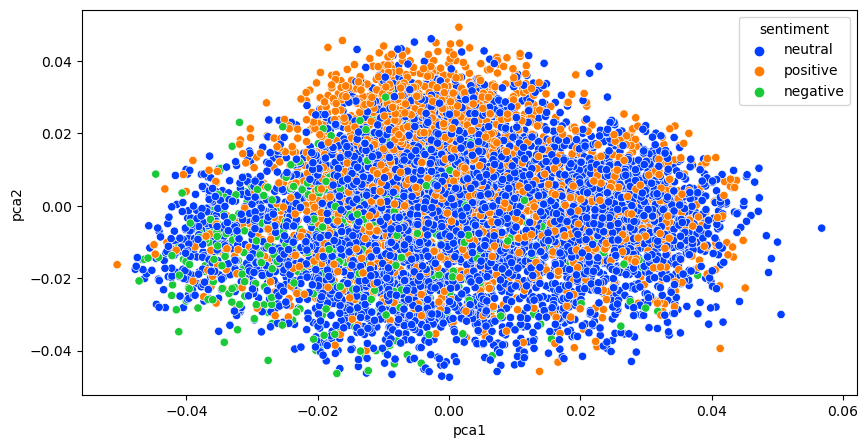

In [73]:
# get 2 principal components of the embeddings

# creating higher order polynomial features
# poly = PolynomialFeatures(2)  # set polynomial degree
# sentence_embeddings_poly = poly.fit_transform(sentence_embeddings.tolist())

# get 2 principal components

# using PCA
# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(sentence_embeddings.tolist())
# using KernelPCA
kpca = KernelPCA(n_components=2, kernel='poly', degree=1)
principal_components = kpca.fit_transform(sentence_embeddings.tolist())

pca_df = pd.DataFrame(principal_components, columns=['pca1', 'pca2'])
pca_df['sentiment'] = df['sentiment']
print(pca_df.shape)
pca_df.head(10)


# plot the 2 principal components
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pca_df, x='pca1', y='pca2', hue='sentiment', palette="bright")
plt.show()

Handling Imbalanced Dataset

In [74]:
# handle class imbalancea with SMOTE
sm = SMOTE(sampling_strategy="all", random_state=42, k_neighbors=5)

# histogram of class distribution
hist, bins = np.histogram(y_train, bins=3)
print(f'Original class distribution: {hist}')

X_train, y_train = sm.fit_resample(X_train, y_train) # resample the training set

# histogram of class distribution
hist, bins = np.histogram(y_train, bins=3)
print(f'Resampled class distribution: {hist}')

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

Original class distribution: [ 395 4200 1805]
Resampled class distribution: [4200 4200 4200]


Logistic Regression

In [ ]:
# logistic regression model
clf = linear_model.LogisticRegression(penalty=None, solver='sag', multi_class='auto', max_iter=1000)
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

Logistic Ridge Regression

In [ ]:
# logistic ridge regression model
clf = linear_model.LogisticRegression(penalty='l2', 
                                      C=0.5, 
                                      solver='saga',  
                                      multi_class='auto', 
                                      n_jobs=12, 
                                      max_iter=1000,
                                      class_weight='balanced'
                                     )
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

In [ ]:
# fine tuning logistic ridge regression

# define model evaluation method
def objective(trial):
    c = trial.suggest_float('C', 1e-5, 1e5, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'saga', 'newton-cg', 'liblinear'])
    
    clf = linear_model.LogisticRegression(penalty='l2', 
                                          C=c, 
                                          solver=solver,  
                                          multi_class='auto', 
                                          max_iter=1000,
                                          n_jobs=12,
                                          class_weight='balanced')
    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    return cross_val_score(clf, X_train, y_train, 
                           n_jobs=12, cv=cv, scoring="f1_macro").mean()

# run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, n_jobs=12)

# optimization history
print('Best trial:', study.best_trial.value)
print(f'Best params: {study.best_trial.params}')
# optuna.visualization.matplotlib.plot_optimization_history(study)
# optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_param_importances(study)
optuna.visualization.matplotlib.plot_contour(study)

# create a model with the optimal hyperparameters
print('Training...')
clf = linear_model.LogisticRegression(penalty='l2',
                                    C=study.best_trial.params['C'], 
                                    solver=study.best_trial.params['solver'],
                                    multi_class='auto',
                                    max_iter=1000,
                                    n_jobs=12,
                                    class_weight='balanced'
                                    )
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

Logistic Lasso Regression

In [ ]:
# logistic lasso regression model
clf = linear_model.LogisticRegression(penalty='l1', 
                                      C=1, 
                                      solver='saga',  
                                      multi_class='auto', 
                                      n_jobs=1, 
                                      max_iter=10000
                                     )
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

In [ ]:
# logistic lasso regression model

# define model evaluation method
def objective(trial):
    c = trial.suggest_float('C', 1e-5, 1e5, log=True)
    
    clf = linear_model.LogisticRegression(penalty='l1', 
                                          C=c, 
                                          solver='liblinear',  
                                          multi_class='auto', 
                                          max_iter=5000,
                                          n_jobs=12)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    return cross_val_score(clf, X_train, y_train, 
                           n_jobs=12, cv=cv, scoring='f1_macro').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

# create a model with the optimal hyperparameters
print('Training...')
clf = linear_model.LogisticRegression(penalty='l1',
                                    C=study.best_trial.params['C'],
                                    solver='saga',
                                    multi_class='auto',
                                    max_iter=5000
                                    )
clf = clf.fit(X_train, y_train)

# Evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

SVM

In [ ]:
# svm model
# clf = svm.SVC(kernel='linear', C=1.0, decision_function_shape='ovo') # linear kernel
clf = svm.SVC(kernel='poly', degree=3, C=1.0, decision_function_shape='ovo') # polynomial kernel
# clf = svm.SVC(kernel='rbf', C=1.0, decision_function_shape='ovo') # rbf kernel
# train the model
print("Training the model...")
clf.fit(X_train, y_train)

# evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

Training the model...

Split: train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4200
           1       1.00      0.99      0.99      4200
           2       0.99      1.00      1.00      4200

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600


Split: validation
              precision    recall  f1-score   support

           0       0.41      0.33      0.37        87
           1       0.81      0.87      0.84      1090
           2       0.66      0.58      0.62       423

    accuracy                           0.76      1600
   macro avg       0.63      0.59      0.61      1600
weighted avg       0.75      0.76      0.75      1600



Random Forest

In [ ]:
# random forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
# train the model
print('Training...')
clf = clf.fit(X_train, y_train)

# evaluate our predictor quantitatively
for split_name, dataset in zip(['train', 'validation'], datasets):
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')
    print(skm.classification_report(y_i, y_pred))

# # ROC and precision-recall curves
# # binariaze the labels
# y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
# num_classes = y_val_bin.shape[1]
# # predict the probabilities for each class
# y_pred_bin = clf.predict_proba(X_val)

# # compute the ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_bin[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# print(f'ROC AUC: {roc_auc}')
# # plot the ROC curve
# for i in range(num_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic for class %i' % i)
#     plt.legend(loc="lower right")
#     plt.show()

# # compute the precision-recall curve and average precision score for each class
# precision = dict()
# recall = dict()
# average_precision = dict()
# for i in range(num_classes):
#     precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_pred_bin[:, i])
#     average_precision[i] = average_precision_score(y_val_bin[:, i], y_pred_bin[:, i])
# # plot the precision-recall curve
# for i in range(num_classes):
#     plt.figure()
#     plt.plot(recall[i], precision[i], label='Precision-recall curve (area = %0.2f)' % average_precision[i])
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('Recall (sensitivity)')
#     plt.ylabel('Precision (PPV)')
#     plt.title('Precision-recall curve for class %i' % i)
#     plt.legend(loc="lower right")
#     plt.show()

Training...

Split: train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4200
           1       1.00      1.00      1.00      4200
           2       1.00      1.00      1.00      4200

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600


Split: validation
              precision    recall  f1-score   support

           0       0.23      0.13      0.16        87
           1       0.76      0.89      0.82      1090
           2       0.65      0.42      0.51       423

    accuracy                           0.72      1600
   macro avg       0.55      0.48      0.50      1600
weighted avg       0.70      0.72      0.70      1600



Save the best model for test set

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
sentences_test = list(df_test.words_str.values)
X_test = model.encode(sentences_test)
y_hat = clf.predict(X_test)

# convert clf model back to categorical
y_hat = le.inverse_transform(y_hat)
print(f"y_hat: ", y_hat.shape)
print(y_hat[0:5])

# Save the results with the format <TEAM_ID>__<SPLIT>_clf_pred.npy
directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)

Deep Learning

In [ ]:
# create dataset and data loader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to("cuda"), torch.from_numpy(y_train).to("cuda"))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to("cuda"), torch.from_numpy(y_val).to("cuda"))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# create model
class SimpleFeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleFeedforwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        output = self.model(x)
        return output


In [ ]:
# initialize model and loss function
input_size = 768
hidden_size = 32
num_classes = 3
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFeedforwardNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-1)

In [ ]:
# train model

# Lists to store losses and metrics
train_losses = []
val_losses = []

# training loop
for epoch in range(num_epochs):
    # training
    model.train()
    running_loss = 0.0
    for data in train_loader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # append loss
    train_losses.append(running_loss / len(train_loader))

    # validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            # get the inputs
            inputs, labels = data
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

    # append loss
    val_losses.append(running_loss / len(val_loader))

    # print epoch statistics
    print(f'Epoch {epoch + 1} / {num_epochs} | '
          f'Train loss: {train_losses[-1]:.4f} | '
          f'Val loss: {val_losses[-1]:.4f}')

Epoch 1 / 20 | Train loss: 0.7505 | Val loss: 0.7890
Epoch 2 / 20 | Train loss: 0.5969 | Val loss: 0.7348
Epoch 3 / 20 | Train loss: 0.5413 | Val loss: 0.7638
Epoch 4 / 20 | Train loss: 0.5134 | Val loss: 0.7302
Epoch 5 / 20 | Train loss: 0.4845 | Val loss: 0.7197
Epoch 6 / 20 | Train loss: 0.4636 | Val loss: 0.7143
Epoch 7 / 20 | Train loss: 0.4434 | Val loss: 0.6972
Epoch 8 / 20 | Train loss: 0.4272 | Val loss: 0.7129
Epoch 9 / 20 | Train loss: 0.4134 | Val loss: 0.7286
Epoch 10 / 20 | Train loss: 0.4008 | Val loss: 0.7118
Epoch 11 / 20 | Train loss: 0.3874 | Val loss: 0.7125
Epoch 12 / 20 | Train loss: 0.3756 | Val loss: 0.7193
Epoch 13 / 20 | Train loss: 0.3707 | Val loss: 0.7148
Epoch 14 / 20 | Train loss: 0.3571 | Val loss: 0.7111
Epoch 15 / 20 | Train loss: 0.3512 | Val loss: 0.7091
Epoch 16 / 20 | Train loss: 0.3431 | Val loss: 0.7137
Epoch 17 / 20 | Train loss: 0.3360 | Val loss: 0.6957
Epoch 18 / 20 | Train loss: 0.3284 | Val loss: 0.7199
Epoch 19 / 20 | Train loss: 0.3199 | 

Use Trained Embeddings

In [ ]:
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# load model
MODEL = f"./models/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to('cuda')
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# create labels
predictions = []
df = pd.read_csv('dataset/tweets_train.csv')
labels = df['sentiment'].values

# prediction on training set
for i in range(0, len(df), 100):
    df_sub = df[i:i+100] #subsetting the data to avoid memory error
    labels_sub = df_sub['sentiment'].values
    input_sequences_classification = tokenizer(df_sub['text'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

    model.eval()
    with torch.no_grad():
        outputs = model(input_sequences_classification['input_ids'].to('cuda')).logits.squeeze().cpu().numpy()

    for output in outputs:
        scores = output
        scores = softmax(scores)

        ranking = np.argsort(scores)
        ranking = ranking[::-1]
        l = labels[ranking[0]]
        predictions.append(l)

# print classification report
print(len(predictions))
print(len(labels))
print(skm.classification_report(labels, predictions, zero_division=1))

8000
8000
              precision    recall  f1-score   support

    negative       1.00      0.00      0.00       482
     neutral       0.66      1.00      0.80      5290
    positive       1.00      0.00      0.00      2228

    accuracy                           0.66      8000
   macro avg       0.89      0.33      0.27      8000
weighted avg       0.78      0.66      0.53      8000

